In [1]:
import pandas as pd
import numpy as np
import os
import xgboost as xgb
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
import operator
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import KFold
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

C:\Users\Kohei\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data_path = 'C:/Users/Kohei/Documents/Kaggle/Recruit/02_data/02_17a/'
path = 'C:/Users/Kohei/Documents/Kaggle/Recruit/22_ensemble/22_19ae/'
ver = '22_19ae_ensemble'

pred_path = 'C:/Users/Kohei/Documents/Kaggle/Recruit/'

In [3]:
ID = ['air_store_id','visit_date','flag']
TARGET='visitors'

In [4]:
def RMSLE(y, pred):
    return mean_squared_error(y, pred) ** 0.5

In [5]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

In [30]:
models = [#'03_xgb/03_15ac/03_15ac_xgb',\
          '03_xgb/03_17bb/03_17bb_xgb',\
#           '03_xgb/03_17c/03_17c_xgb',\
#           #'03_xgb/03_17d/03_17d_xgb',\
#           '03_xgb/03_17e/03_17e_xgb',\
#           '03_xgb/03_17f/03_17f_xgb',\
#           #'03_xgb/03_17g/03_17g_xgb',\
          '03_xgb/03_19ab/03_19ab_xgb',\
          '03_xgb/03_19ah/03_19ah_xgb',\
          '03_xgb/03_19aj/03_19aj_xgb',\
          '03_xgb/03_19al/03_19al_xgb',\
          '04_lgb/04_19ab/04_19ab_lgb',\
          '04_lgb/04_19abb/04_19abb_lgb',\
          #'04_lgb/04_19ac/04_19ac_lgb',\
          #'04_lgb/04_19ae/04_19ae_lgb',\
          '04_lgb/04_19af/04_19af_lgb',\
          '04_lgb/04_19ag/04_19ag_lgb',\
          '05_catboost/05_19ac/05_19ac_catboost',\
          '05_catboost/05_19acb/05_19acb_catboost',\
          '05_catboost/05_19ad/05_19ad_catboost',\
          '05_catboost/05_19af/05_19af_catboost',\
          '05_catboost/05_19ai/05_19ai_catboost',\
          #'05_catboost/05_19ak/05_19ak_catboost',\
          '06_keras/06_19ac/06_19ac_keras']
          #'06_keras/06_19af/06_19af_keras']
          #'06_keras/06_19aj/06_19aj_keras']
#           '07_knn/07_19ad/07_19ad_knn',\
#           '07_knn/07_19ag/07_19ag_knn']
          #'07_knn/07_19ah/07_19ah_knn']

tr1 = pd.read_csv(os.path.join(data_path, 'train1.csv'))[['air_store_id','visit_date','flag','visitors']]
tr2 = pd.read_csv(os.path.join(data_path, 'train2.csv'))[['air_store_id','visit_date','flag','visitors']]
tr1['visit_date'] = pd.to_datetime(tr1['visit_date'])
tr2['visit_date'] = pd.to_datetime(tr2['visit_date'])
# tr1 = tr1[tr1.visit_date>=(date(2017,4,23)-timedelta(days=330))]
# tr2 = tr2[tr2.visit_date>=(date(2017,4,23)-timedelta(days=360))]

te = pd.read_csv(os.path.join(data_path, 'test_all.csv'))[['air_store_id','visit_date','flag']]
te['visit_date'] = pd.to_datetime(te['visit_date'])

for i, x in enumerate(models):
    # train
    pred_tr1 = pd.read_csv(pred_path+x+'_pred_tr1.csv')[['air_store_id','visit_date','pred']].rename(columns={'pred':'pred_'+str(i+1)})
    pred_tr1['visit_date'] = pd.to_datetime(pred_tr1['visit_date'])
    tr1 = pd.merge(tr1, pred_tr1, how='left', on=['air_store_id','visit_date'])
      
    pred_tr2 = pd.read_csv(pred_path+x+'_pred_tr2.csv')[['air_store_id','visit_date','pred']].rename(columns={'pred':'pred_'+str(i+1)})
    pred_tr2['visit_date'] = pd.to_datetime(pred_tr2['visit_date'])
    tr2 = pd.merge(tr2, pred_tr2, how='left', on=['air_store_id','visit_date'])
    
    # test
    pred_te1 = pd.read_csv(pred_path+x+'_pred_te1.csv')[['air_store_id','visit_date','pred']].rename(columns={'pred':'pred_'+str(i+1)})
    pred_te1['visit_date'] = pd.to_datetime(pred_te1['visit_date'])
    
    pred_te2 = pd.read_csv(pred_path+x+'_pred_te2.csv')[['air_store_id','visit_date','pred']].rename(columns={'pred':'pred_'+str(i+1)})
    pred_te2['visit_date'] = pd.to_datetime(pred_te2['visit_date'])
    
    pred_te = pd.concat([pred_te1,pred_te2])
    te = pd.merge(te, pred_te, how='left', on=['air_store_id','visit_date'])

In [39]:
pred_names = ['pred_1','pred_2','pred_3','pred_4','pred_5','pred_6','pred_7','pred_8','pred_9','pred_10',\
              'pred_11','pred_12','pred_13','pred_14','pred_15']
def corr_plot(df):
    corr = df[pred_names].corr()
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr, vmin=0.95, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,len(pred_names),1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(pred_names)
    ax.set_yticklabels(pred_names)
    plt.show()

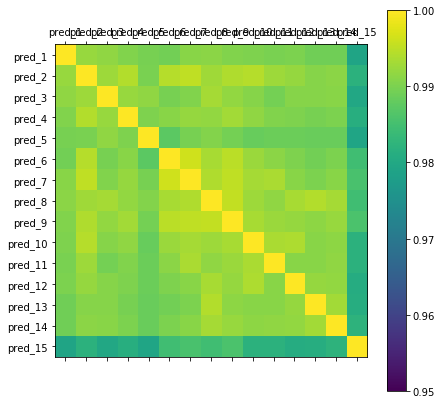

In [40]:
corr_plot(tr1)

In [36]:
def model_run(df):
    test = te.copy()
    if df=='train1':
        train = tr1.copy()
        test = test.loc[test.flag==1,:].reset_index(drop=True)
    elif df=='train2':
        train = tr2.copy()
        test = test.loc[test.flag==2,:].reset_index(drop=True)
        
    y_train = np.log1p(train['visitors'])
    id_train = train[ID]
    id_test  = test[ID]
    x_train = train
    x_test = test
    x_train.drop(ID, axis=1, inplace=True)
    x_train.drop(TARGET, axis=1, inplace=True)
    x_test.drop(ID, axis=1, inplace=True)
    del train, test
            
    n_folds = 4
    bagging = 5
    divisor = 1
    cv_sum = 0
    pred_tr_all = []
    pred_te_all = []

    kf = KFold(x_train.shape[0], n_folds=n_folds, random_state=5678, shuffle=True)

    nrounds = 80000
    verbose_eval = 200
    early_stopping_rounds = 20

    d_test = xgb.DMatrix(x_test)

    for i, (tr_index,vl_index) in enumerate(kf):
        print('\nFold %d / %d' % (i+1, n_folds))
        pred = []
        pred_vl = []

        x_tr, x_vl = x_train.loc[tr_index].copy(), x_train.loc[vl_index].copy()
        y_tr, y_vl = y_train[tr_index], y_train[vl_index]
        id_vl      = id_train.loc[vl_index].copy()
        
        for j in range(1,bagging+1):
            print('\nBagging %d / %d' % (j, bagging))

            # sampling
#             np.random.seed(j)
#             sample = np.random.choice(len(x_tr), size=int(len(x_tr)/divisor))
#             x_tr_bag = x_tr.iloc[sample]
#             y_tr_bag = y_tr.iloc[sample]
            x_tr_bag = x_tr
            y_tr_bag = y_tr

            d_train = xgb.DMatrix(x_tr_bag, label=y_tr_bag)
            d_valid = xgb.DMatrix(x_vl, label=y_vl)
            watchlist = [(d_train,'train'),(d_valid,'valid')]

            params = {'seed': (j-1),
                      'subsample': 0.8,
                      'colsample_bytree': (j%2)*0.1+0.7,
#                       'colsample_bytree': 0.8,
                      'silent': 1,
                      'learning_rate': 0.05,
                      'objective': 'reg:linear',
                      'max_depth': (j%3)+2,
#                       'max_depth': 4,
                      'min_child_weight': 10,
                      'alpha': 0, # default=0
                      'lambda': 1,# default=1
                      'gamma': 0, # default=0
                      'booster': 'gbtree'}

            clf = xgb.train(params,
                            d_train,
                            nrounds,
                            watchlist,
                            verbose_eval=verbose_eval,
                            early_stopping_rounds = early_stopping_rounds)
            if j==1:
                pred_v = clf.predict(d_valid, ntree_limit=clf.best_ntree_limit)
                pred_t = clf.predict(d_test, ntree_limit=clf.best_ntree_limit)
            else:
                pred_v += clf.predict(d_valid, ntree_limit=clf.best_ntree_limit)    
                pred_t += clf.predict(d_test, ntree_limit=clf.best_ntree_limit)    
            pred_vl = (pred_v/j)
            pred_te = (pred_t/j)

            cv_score = RMSLE(y_vl, pred_vl)
            print('Fold RMSLE : %.6f' % cv_score)

        # end of bagging
        pred = id_vl
        pred['pred'] = pred_vl

        if i==0:
            pred_tr_all = pred
            pred_te_all = pred_te
        else:
            pred_tr_all = pd.concat([pred_tr_all,pred])
            pred_te_all += pred_te

        cv_sum = cv_sum + cv_score

    pred_te_all /= n_folds
    pred_te_all = pd.DataFrame({'pred':pred_te_all})
    pred_te_all = pd.concat([id_test,pred_te_all],axis=1)

    print('CV RMSLE : %.6f' % (cv_sum / n_folds))
    
    # variable importance
    feature_names = x_train.columns
    create_feature_map(feature_names)
    importance = clf.get_fscore(fmap='xgb.fmap')
    importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)
    varimp = pd.DataFrame(importance, columns=['feature', 'fscore'])
    varimp.to_csv(path+'/'+ver+'_varimp_'+df+'.csv', index=False)

    return pred_tr_all, pred_te_all

In [37]:
### Train1 - Run
pred_tr1_xgb, pred_te1_xgb = model_run('train1')
pred_tr1_xgb.to_csv(path+'/'+ver+'_pred_tr1.csv', index=False)
pred_te1_xgb.to_csv(path+'/'+ver+'_pred_te1.csv', index=False)


Fold 1 / 4

Bagging 1 / 5
[0]	train-rmse:2.31763	valid-rmse:2.32231
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 20 rounds.
Stopping. Best iteration:
[167]	train-rmse:0.493201	valid-rmse:0.496702

Fold RMSLE : 0.496702

Bagging 2 / 5
[0]	train-rmse:2.31743	valid-rmse:2.32212
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 20 rounds.
Stopping. Best iteration:
[129]	train-rmse:0.492357	valid-rmse:0.49677

Fold RMSLE : 0.496682

Bagging 3 / 5
[0]	train-rmse:2.31816	valid-rmse:2.32293
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 20 rounds.
[200]	train-rmse:0.494029	valid-rmse:0.496846
Stopping. Best iteration:
[222]	train-rmse:0.493922	valid-rmse:0.496825

Fold RMSLE : 0.496679

Bagging 4 / 5
[0]	train-rmse:2.31761	valid-rmse:2.3

In [38]:
### Train2 - Run
pred_tr2_xgb, pred_te2_xgb = model_run('train2')
pred_tr2_xgb.to_csv(path+'/'+ver+'_pred_tr2.csv', index=False)
pred_te2_xgb.to_csv(path+'/'+ver+'_pred_te2.csv', index=False)


Fold 1 / 4

Bagging 1 / 5
[0]	train-rmse:2.3158	valid-rmse:2.32011
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 20 rounds.
[200]	train-rmse:0.508694	valid-rmse:0.507156
Stopping. Best iteration:
[265]	train-rmse:0.507959	valid-rmse:0.507051

Fold RMSLE : 0.507051

Bagging 2 / 5
[0]	train-rmse:2.31555	valid-rmse:2.31988
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 20 rounds.
Stopping. Best iteration:
[157]	train-rmse:0.507562	valid-rmse:0.507096

Fold RMSLE : 0.507016

Bagging 3 / 5
[0]	train-rmse:2.31634	valid-rmse:2.32064
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 20 rounds.
[200]	train-rmse:0.509942	valid-rmse:0.507373
[400]	train-rmse:0.508923	valid-rmse:0.507168
Stopping. Best iteration:
[424]	train-rmse:0.508816	val

In [41]:
pred_te_xgb = pd.concat([pred_te1_xgb,pred_te2_xgb])
tr1 = pd.merge(tr1, pred_tr1_xgb, on=['air_store_id','visit_date','flag'], how='left').rename(columns={'pred':'pred_stack'})
tr2 = pd.merge(tr2, pred_tr2_xgb, on=['air_store_id','visit_date','flag'], how='left').rename(columns={'pred':'pred_stack'})
te  = pd.merge(te,  pred_te_xgb,  on=['air_store_id','visit_date','flag'], how='left').rename(columns={'pred':'pred_stack'})

In [42]:
# Stacking
cv_public = RMSLE(np.log1p(tr1['visitors']), tr1['pred_stack'])
cv_private = RMSLE(np.log1p(tr2['visitors']), tr2['pred_stack'])
cv_total = (cv_public*6+cv_private*33)/39

print('Public  RMSLE: %.6f' % cv_public)
print('Private RMSLE: %.6f' % cv_private)
print('Total   RMSLE: %.6f' % cv_total)

Public  RMSLE: 0.495745
Private RMSLE: 0.510195
Total   RMSLE: 0.507972


In [154]:
# Simple Average
w1 = 0.50
w2 = 0.10
w3 = 0.00
w4 = 0.00
w5 = 0.15
w6 = 0.00
w7 = 0.00
w8 = 0.00
w9 = 0.00
w10 = 0.15
w11 = 0.10
w12 = 0.00
w13 = 0.00
w14 = 0.00
w15 = 0.00
tr1['pred_sim'] = (tr1['pred_1']*w1 + tr1['pred_2']*w2 + tr1['pred_3']*w3 + tr1['pred_4']*w4 + tr1['pred_5']*w5 +\
                   tr1['pred_6']*w6 + tr1['pred_7']*w7 + tr1['pred_8']*w8 + tr1['pred_9']*w9 + tr1['pred_10']*w10 +\
                   tr1['pred_11']*w11 + tr1['pred_12']*w12 + tr1['pred_13']*w13 + tr1['pred_14']*w14 + tr1['pred_15']*w15)
tr2['pred_sim'] = (tr2['pred_1']*w1 + tr2['pred_2']*w2 + tr2['pred_3']*w3 + tr2['pred_4']*w4 + tr2['pred_5']*w5 +\
                   tr2['pred_6']*w6 + tr2['pred_7']*w7 + tr2['pred_8']*w8 + tr2['pred_9']*w9 + tr2['pred_10']*w10 +\
                   tr2['pred_11']*w11 + tr2['pred_12']*w12 + tr2['pred_13']*w13 + tr2['pred_14']*w14 + tr2['pred_15']*w15)
te['pred_sim']  = (te['pred_1']*w1 + te['pred_2']*w2 + te['pred_3']*w3 + te['pred_4']*w4 + te['pred_5']*w5 +\
                   te['pred_6']*w6 + te['pred_7']*w7 + te['pred_8']*w8 + te['pred_9']*w9 + te['pred_10']*w10 +\
                   te['pred_11']*w11 + te['pred_12']*w12 + te['pred_13']*w13 + te['pred_14']*w14 + te['pred_15']*w15)

cv_public = RMSLE(np.log1p(tr1['visitors']), tr1['pred_sim'])
cv_private = RMSLE(np.log1p(tr2['visitors']), tr2['pred_sim'])
cv_total = (cv_public*6+cv_private*33)/39

print('Public  RMSLE: %.6f' % cv_public)
print('Private RMSLE: %.6f' % cv_private)
print('Total   RMSLE: %.6f' % cv_total)

Public  RMSLE: 0.495768
Private RMSLE: 0.510453
Total   RMSLE: 0.508194


In [163]:
# 3rd layer
a = 0.70
b = (1-a)
tr1['pred_3rd'] = (tr1['pred_stack']*a + tr1['pred_sim']*b)
tr2['pred_3rd'] = (tr2['pred_stack']*a + tr2['pred_sim']*b)
te['pred_3rd']  = (te['pred_stack']*a + te['pred_sim']*b)

cv_public = RMSLE(np.log1p(tr1['visitors']), tr1['pred_3rd'])
cv_private = RMSLE(np.log1p(tr2['visitors']), tr2['pred_3rd'])
cv_total = (cv_public*6+cv_private*33)/39

print('Public  RMSLE: %.6f' % cv_public)
print('Private RMSLE: %.6f' % cv_private)
print('Total   RMSLE: %.6f' % cv_total)

Public  RMSLE: 0.495611
Private RMSLE: 0.510124
Total   RMSLE: 0.507891


In [195]:
# submission - stacking
sub = pd.read_csv('C:/Users/Kohei/Documents/Kaggle/Recruit/00_input/sample_submission.csv')
sub['air_store_id'] = sub.id.map(lambda x: '_'.join(x.split('_')[:-1]))
sub['visit_date']   = sub.id.map(lambda x: x.split('_')[2])
sub['visit_date'] = pd.to_datetime(sub['visit_date'])

# before adjustment
sub.loc[:,'visitors'] = sub.merge(te, on=['air_store_id','visit_date'], how='left')['pred_stack'].values
sub['visitors'] = np.expm1(sub['visitors'])
sub_file = path+'/'+ver+'_stack.csv'
sub[['id','visitors']].to_csv(sub_file, index=False)

# after adjustment
sub['pred'] = sub['visitors']
sub.loc[sub.visit_date==date(2017,4,25),'visitors']*=1.10 # Tuesday
sub.loc[sub.visit_date==date(2017,4,26),'visitors']*=1.00 # Wednesday
sub.loc[sub.visit_date==date(2017,4,27),'visitors']*=1.10 # Thursday
sub.loc[sub.visit_date==date(2017,4,28),'visitors']*=1.00 # Friday
sub.loc[sub.visit_date==date(2017,4,29),'visitors']*=1.00 # Saturday & Holiday
sub.loc[sub.visit_date==date(2017,4,30),'visitors']*=1.30 # Sunday - Original prediction is too low compared to the same date in 2016 
sub.loc[sub.visit_date==date(2017,5,1),'visitors'] *=1.40 # Monday - between weekend and golden week. 1.08 is best in 2016.
sub.loc[sub.visit_date==date(2017,5,2),'visitors'] *=1.10 # Tuesday - between weekend and golden week. 1.08 is best on Monday, 5/2/2016, which was also between weekend and holiday.
sub.loc[sub.visit_date==date(2017,5,3),'visitors'] *=1.10 # Day1
sub.loc[sub.visit_date==date(2017,5,4),'visitors'] *=1.05 # Day2
sub.loc[sub.visit_date==date(2017,5,5),'visitors'] *=1.05 # Day3
sub.loc[sub.visit_date==date(2017,5,6),'visitors'] *=1.00 # Saturday
sub.loc[sub.visit_date==date(2017,5,7),'visitors'] *=1.10 # Sunday
sub.loc[sub.visit_date==date(2017,5,8),'visitors'] *=0.95 # Monday
sub.loc[sub.visit_date==date(2017,5,9),'visitors'] *=0.95 # Tuesday
sub.loc[sub.visit_date==date(2017,5,10),'visitors']*=1.00 # Wednesday
sub_file = path+'/'+ver+'_stack_adjusted.csv'
sub[['id','visitors']].to_csv(sub_file, index=False)

In [196]:
# submission - 3rd
sub = pd.read_csv('C:/Users/Kohei/Documents/Kaggle/Recruit/00_input/sample_submission.csv')
sub['air_store_id'] = sub.id.map(lambda x: '_'.join(x.split('_')[:-1]))
sub['visit_date']   = sub.id.map(lambda x: x.split('_')[2])
sub['visit_date'] = pd.to_datetime(sub['visit_date'])

# before adjustment
sub.loc[:,'visitors'] = sub.merge(te, on=['air_store_id','visit_date'], how='left')['pred_3rd'].values
sub['visitors'] = np.expm1(sub['visitors'])
sub_file = path+'/'+ver+'_3rd.csv'
sub[['id','visitors']].to_csv(sub_file, index=False)

# after adjustment
sub['pred'] = sub['visitors']
sub.loc[sub.visit_date==date(2017,4,25),'visitors']*=1.10 # Tuesday
sub.loc[sub.visit_date==date(2017,4,26),'visitors']*=1.00 # Wednesday
sub.loc[sub.visit_date==date(2017,4,27),'visitors']*=1.10 # Thursday
sub.loc[sub.visit_date==date(2017,4,28),'visitors']*=1.00 # Friday
sub.loc[sub.visit_date==date(2017,4,29),'visitors']*=1.00 # Saturday & Holiday
sub.loc[sub.visit_date==date(2017,4,30),'visitors']*=1.30 # Sunday - Original prediction is too low compared to the same date in 2016 
sub.loc[sub.visit_date==date(2017,5,1),'visitors'] *=1.40 # Monday - between weekend and golden week. 1.08 is best in 2016.
sub.loc[sub.visit_date==date(2017,5,2),'visitors'] *=1.10 # Tuesday - between weekend and golden week. 1.08 is best on Monday, 5/2/2016, which was also between weekend and holiday.
sub.loc[sub.visit_date==date(2017,5,3),'visitors'] *=1.10 # Day1
sub.loc[sub.visit_date==date(2017,5,4),'visitors'] *=1.05 # Day2
sub.loc[sub.visit_date==date(2017,5,5),'visitors'] *=1.05 # Day3
sub.loc[sub.visit_date==date(2017,5,6),'visitors'] *=1.00 # Saturday
sub.loc[sub.visit_date==date(2017,5,7),'visitors'] *=1.10 # Sunday
sub.loc[sub.visit_date==date(2017,5,8),'visitors'] *=0.95 # Monday
sub.loc[sub.visit_date==date(2017,5,9),'visitors'] *=0.95 # Tuesday
sub.loc[sub.visit_date==date(2017,5,10),'visitors']*=1.00 # Wednesday
sub_file = path+'/'+ver+'_3rd_adjusted.csv'
sub[['id','visitors']].to_csv(sub_file, index=False)

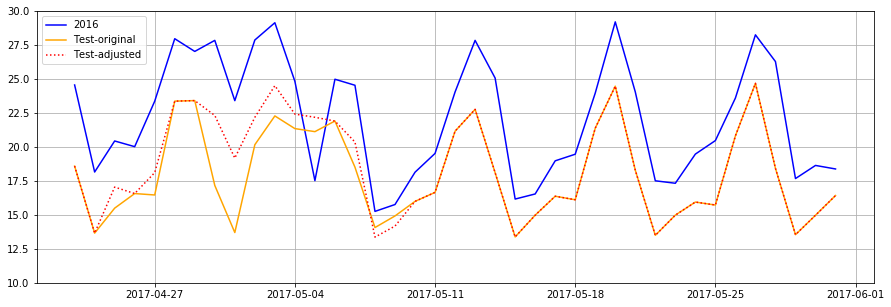

In [197]:
# 2016 Act vs 2017 Pred
pred = pd.DataFrame(sub.groupby(['visit_date'])['pred','visitors'].mean().reset_index()).rename(columns={'visitors':'pred_adj'})

train = pd.read_csv('C:/Users/Kohei/Documents/Kaggle/Recruit/00_input/air_visit_data.csv')[['visit_date','visitors']]
train['visit_date'] = pd.to_datetime(train['visit_date'])
train['visit_date'] = train['visit_date']+timedelta(days=365-1)
df = train[train.visit_date>=date(2017,4,23)]
df = df[df.visit_date<=date(2017,5,31)]
df = pd.DataFrame(df.groupby(['visit_date'])['visitors'].mean().reset_index())

df = df.merge(pred, on='visit_date', how='left')

fig = plt.figure(figsize=(15,5))
plt.plot(df.visit_date, df.visitors, "blue", label = "2016")
plt.plot(df.visit_date, df.pred, "orange", label = "Test-original")
plt.plot(df.visit_date, df.pred_adj, "red", label = "Test-adjusted", linestyle='dotted')
plt.ylim(10,30)
plt.legend(loc='upper left')
plt.grid()